In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import networkx as nx
import argparse
import random
import numpy as np
from tqdm import tqdm
import os

from nnc_snr import *

In [13]:
args = argparse.Namespace(epochs=50, batch_size=32, input_size=392, hidden_size=256, \
                          output_size=256, train_snr=40, val_snr=40, power=1, \
                        learning_rate=0.001, device='cuda:2', model_path='run1', \
                            dropout=False, test=False, scale_outputs=False,\
                                dataset='mnist')

if args.device == 'cpu':
    device = torch.device("cpu") 
elif 'cuda' in args.device:
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")
elif args.device == 'mps':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

train_sigma = snr_db2sigma(args.train_snr)
val_sigma = snr_db2sigma(args.val_snr)
test_snr = np.arange(-60, 60, 10)
test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])
if not args.scale_outputs:       
    eq_train_sigma = train_sigma / np.sqrt(args.power)  
    eq_val_sigma = val_sigma / np.sqrt(args.power)
    eq_test_sigma = test_sigma / np.sqrt(args.power)
    scale_power = 1
else:
    eq_train_sigma = train_sigma
    eq_val_sigma = val_sigma
    eq_test_sigma = test_sigma
    scale_power = args.power

In [14]:
if args.dataset == 'mnist':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'fashion':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'cifar10':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'stl10':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = torchvision.datasets.STL10(root='./data', split='train', transform=transform, download=True)
    test_dataset = torchvision.datasets.STL10(root='./data', split='test', transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
sample_image, _ = train_dataset[0]
input_size = sample_image.size(2)*sample_image.size(1)*sample_image.size(0) // 2
model = ButterflyNetwork(input_size, args.hidden_size, args.output_size, eq_train_sigma, scale_power).to(device)
    


In [15]:
model_path = 'models/nrun1_snr_0/model.pt'


In [17]:

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    # snr_range = np.arange(0, 60, 10)
    result = test(model, test_loader, eq_test_sigma, device)
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

    result = test_dropped(model, test_loader, eq_test_sigma, device, ['AE'])
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
else:
    print(f"No model found at {model_path}")

Loaded model:
 SNR range: (-60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0)
 Test Loss: 1229.9182, 125.9229, 13.9019, 1.8028, 0.2295, 0.0508, 0.0335, 0.0318, 0.0317, 0.0316, 0.0316, 0.0316
 Test PSNR: -21.8892, -11.9915, -2.4212, 6.4501, 15.4021, 21.9499, 23.7541, 23.9821, 24.0057, 24.0078, 24.0081, 24.0081
Loaded model:
 SNR range: (-60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0)
 Test Loss: 1224.0912, 124.7069, 13.8262, 1.9900, 0.5178, 0.3538, 0.3374, 0.3358, 0.3357, 0.3356, 0.3356, 0.3356
 Test PSNR: -21.8686, -11.9493, -2.3975, 6.0210, 11.8675, 13.5216, 13.7278, 13.7482, 13.7506, 13.7509, 13.7509, 13.7509


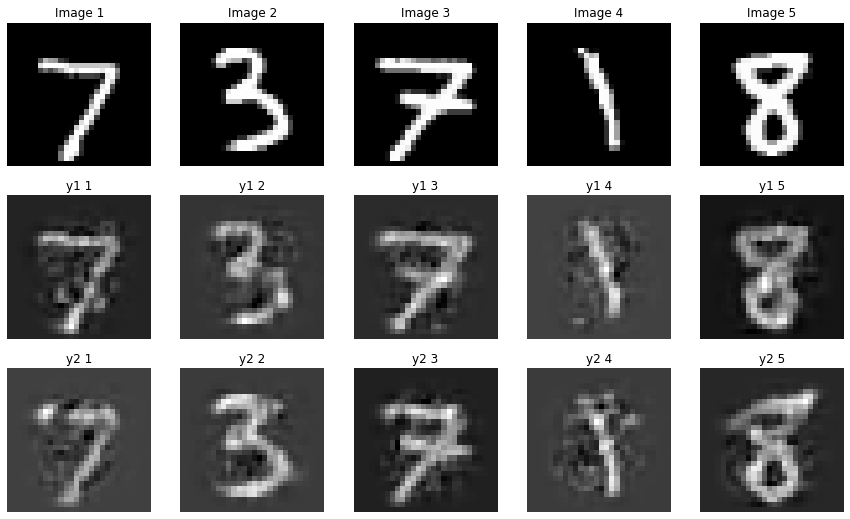

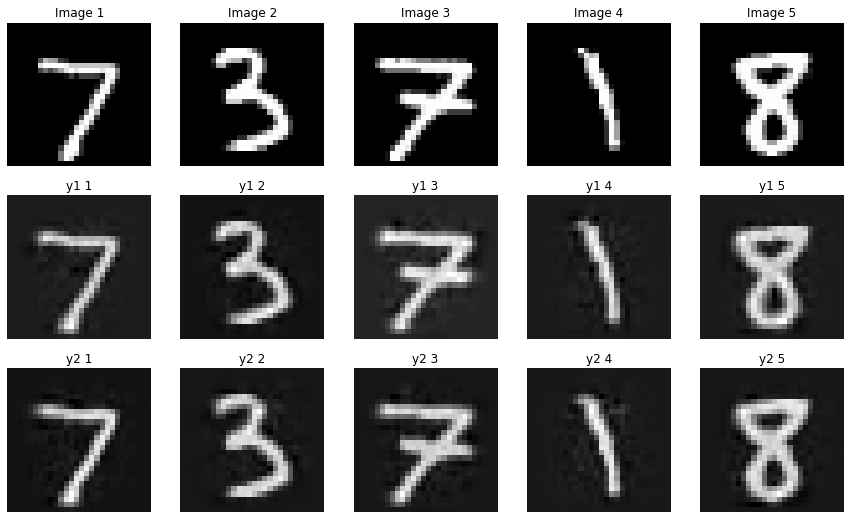

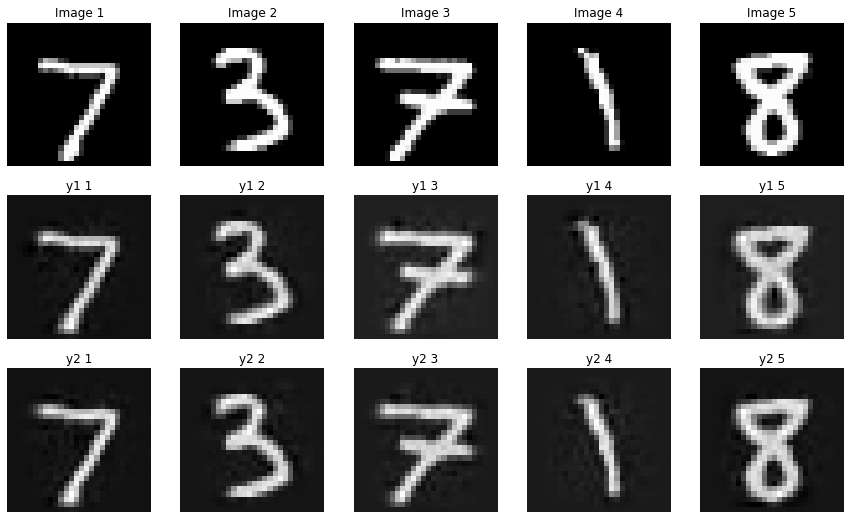

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

model_path = 'models/nrun1_snr_0/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


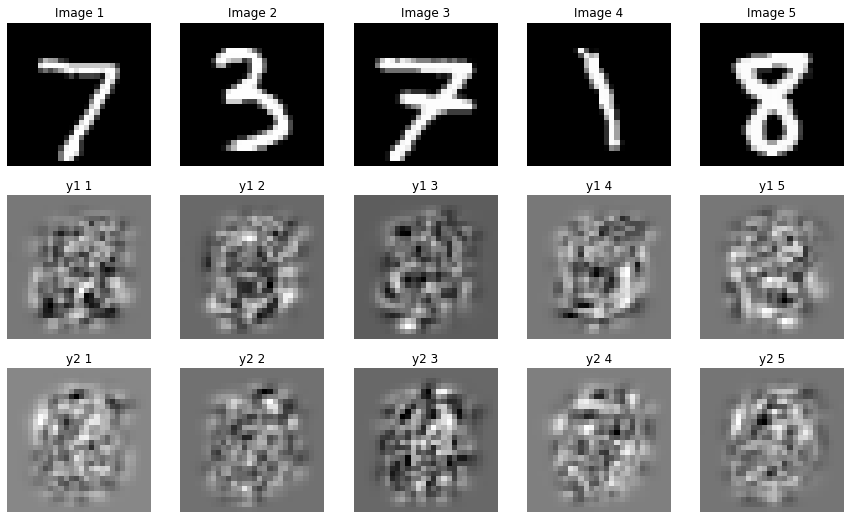

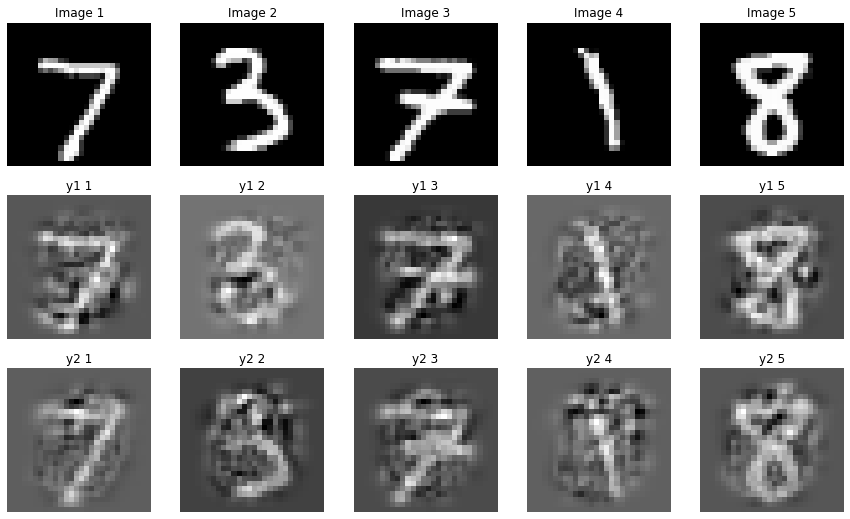

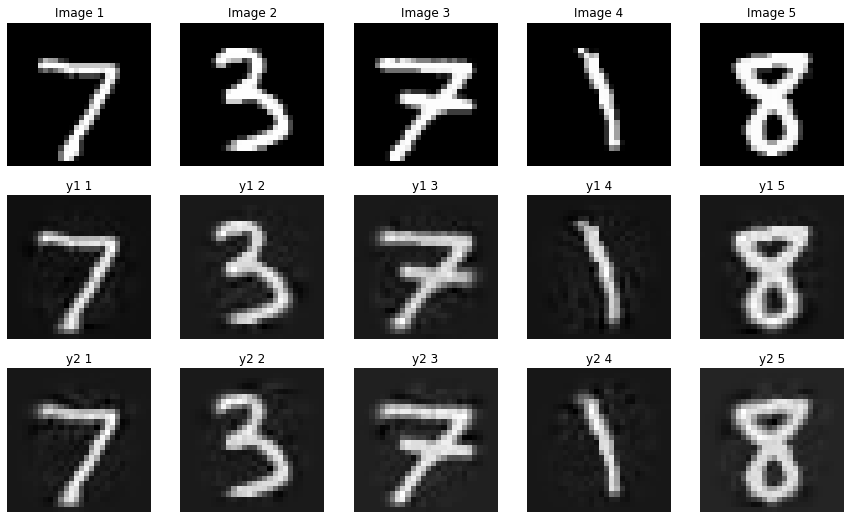

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

model_path = 'models/nrun1_snr_40/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


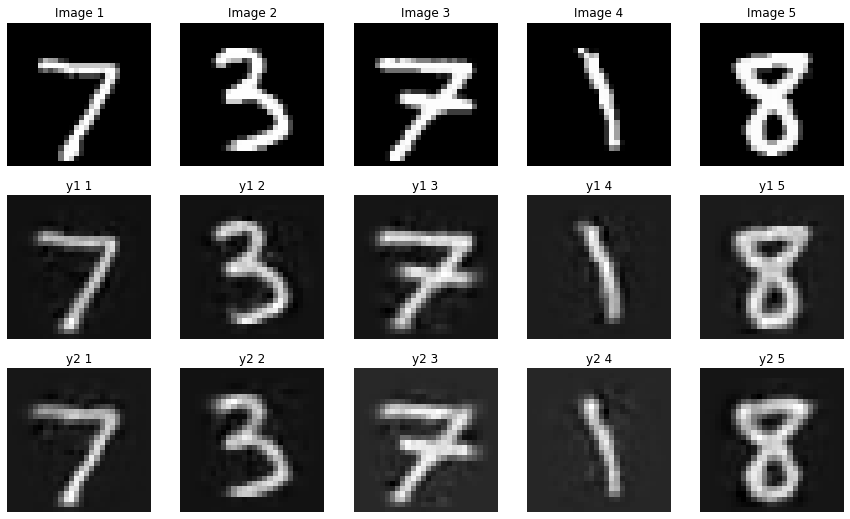

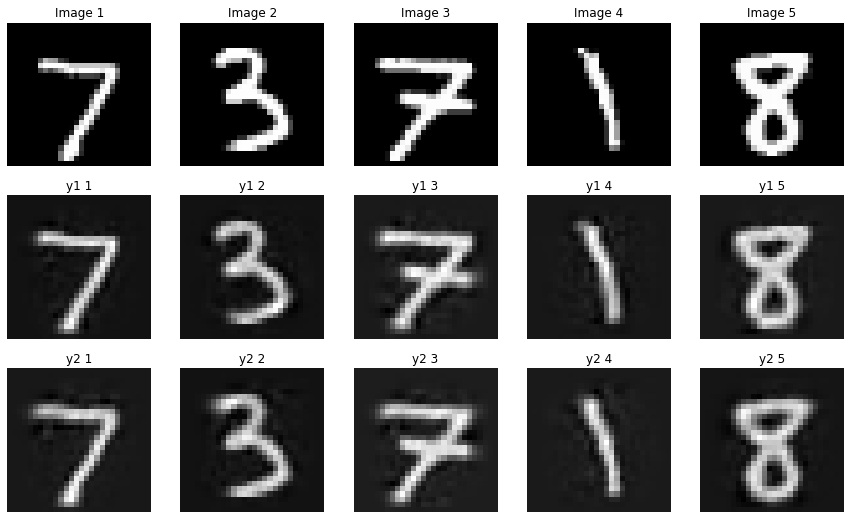

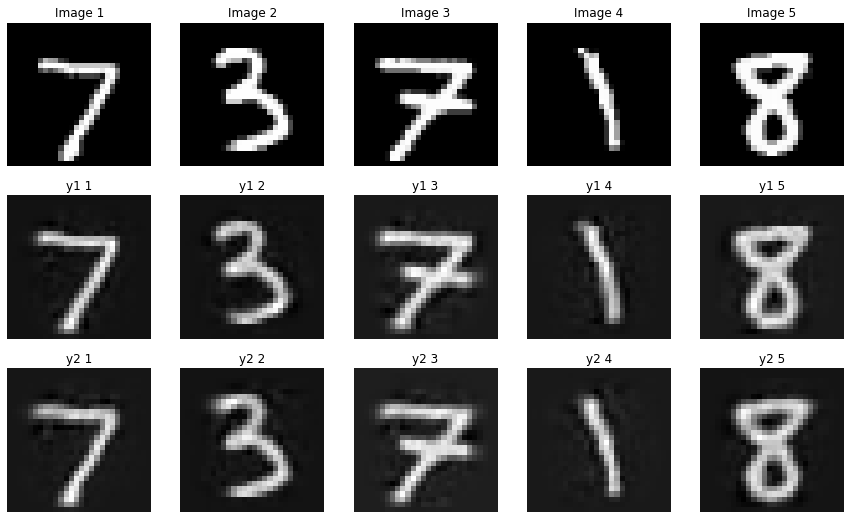

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

model_path = 'models/nrun1_snr_-20/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()
